In [21]:
import numpy as np
import matplotlib.pyplot as plt
import time

G = 1.0  # Gravitational constant


In [10]:
class Planet:
    def __init__(self, mass, position, velocity):
        self.mass = mass
        self.position = np.array(position)
        self.velocity = np.array(velocity)
        
        
    # added functions so we can treat a planet the same as a node
    def get_total_mass(self):
        return self.mass
    def get_com_position(self):
        return self.position

In [11]:
class Node:
    # the bounds should give two points
    # top right and bottom left
    def __init__(self, bounds, limit, index):
        self.bounds = bounds
        self.limit = limit
        self.index = index
        self.children = []
        #print("New Node created at index ", index)
        
        
        # we will define these upon first usage
        self.total_mass = None
        self.com_position = None
        self.expansion_coefficient = None
        self.Q = None
        
        
    def build(self, planets):
        # we want to filter all the planets (0 <= x <= 1 and 0 <= y <= 1)
        #self.planets = [p for p in planets if (self.bounds[0][0] <= p.position[0] <= self.bounds[1][0] and self.bounds[1][1] <= p.position[0] <= self.bounds[0][1])]
        self.planets = planets
        
        if(len(self.planets) > self.limit):    
            xmid = (self.bounds[0][0] + self.bounds[1][0]) / 2
            ymid = (self.bounds[0][1] + self.bounds[1][1]) / 2

            new_bounds = [
                [[self.bounds[0][0], ymid], [xmid, self.bounds[0][1]]],  # top-left
                [[xmid, ymid], [self.bounds[1][0], self.bounds[0][1]]],  # top-right
                [[self.bounds[0][0], self.bounds[1][1]], [xmid, ymid]],  # bottom-left
                [[xmid, self.bounds[1][1]], [self.bounds[1][0], ymid]]   # bottom-right
            ]
            
            
            for b in new_bounds:
                planets_in_bound = [p for p in planets if (b[0][0] <= p.position[0] <= b[1][0] and b[1][1] <= p.position[1] <= b[0][1])]
                if(len(planets_in_bound) > 0):
                    print("Creating child node at index ", self.index + 1, " with ", len(planets_in_bound), " planets")
                    self.children.append(Node(b, self.limit, self.index + 1))
                    self.children[-1].build(planets_in_bound)   
        
    
    def get_Q(self):
        # using memorisation to avoid recalculation
        if(self.Q is None):
            self.Q = np.zeros((2, 2))
            
            for child in (self.children if len(self.children) > 0 else self.planets):
                m = child.get_total_mass()
                r = child.get_com_position() - self.get_com_position()
                r_mag = np.linalg.norm(r)
                
                identity = np.identity(2)
                self.Q += m * (3 * r * np.transpose(r)  - r_mag**2 * identity)
                
        return self.Q
    
    # this is the function, we will use to calculate the force between any planet and this node
    def calculate_force(self, planet):
        # first we check how far away the 
        y = planet.position - self.get_com_position()
        y_mag = np.linalg.norm(y)
        l = self.get_expansion_coefficient()
        
        force = np.zeros(2)
        # using the Barnes-Hut criterion
        if((l/y_mag) < 0.5):
            # calculate the force using the miltipole expansion
            M = self.get_total_mass()
            
            # monopole term
            F_mono = -G * M * y / (y_mag**3)
            
            # quadrupole term
            yQy = np.transpose(y) @ self.get_Q() @ y
            Qy = self.get_Q() @ y
            F_quad = -G * (Qy / (y_mag**5) - 5/2 * yQy * y / (y_mag**7))
            
            return F_mono + F_quad
            # here we use the moltiploe expansion directly
            pass
        else:
            # here we need to open all fof the child nodes
            for child in self.children:
                force += child.calculate_force(planet)
        return force
        
    # return the total mass of the node 
    def get_total_mass(self):
        # using memoization to avoid recalculating
        if(self.total_mass is None):
            self.total_mass = np.sum([p.mass for p in self.planets])
        return self.total_mass
    
    # returns the position of the center of mass
    def get_com_position(self):
        # using memoization to avoid recalculating
        if(self.com_position is None):
            temp = np.array([p.position * p.mass for p in self.planets])
            total_position = [np.sum(temp[:,0]), np.sum(temp[:,1])]
            self.com_position = total_position / self.get_total_mass()
        return self.com_position
        
    # return the average distance between the planets and the center of mass
    def get_expansion_coefficient(self):
        # using memoization to avoid recalculating
        if(self.expansion_coefficient is None):
            com_position = self.get_com_position()
            self.expansion_coefficient = np.average([np.linalg.norm(p.position - com_position) for p in self.planets])

        return self.expansion_coefficient
        

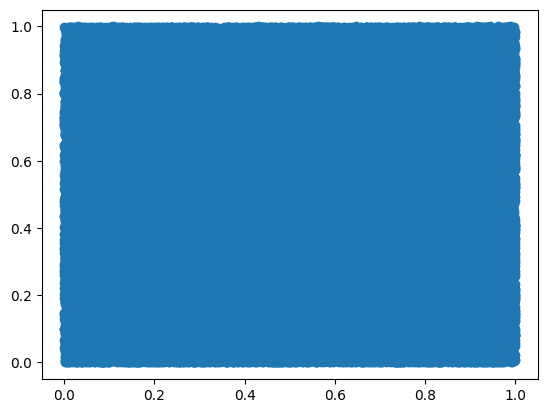

In [16]:
num_planets = 100000
planets = []
for _ in range(num_planets):
    p = Planet(
        1,
        [np.random.rand(), np.random.rand()],
        [0,0]
    )
    planets.append(p)

positions = np.array([p.position for p in planets])
plt.scatter(positions[:,0], positions[:,1])


p = Planet(1, [np.random.rand(), np.random.rand()], [0,0])


#now we check the above calculation using the direct summation
def direct_force(planet, planets):
    force = np.zeros(2)
    for p in planets:
        if p is not planet: 
            r = planet.position - p.position
            r_mag = np.linalg.norm(r)
            force += -G * p.mass * r / (r_mag**3)
    return force


In [ ]:
time_testing = True
if time_testing:
    # now we can ask, how long does it take to build this tree structure?
    N = [1e2, 1e3, 1e4, 1e5, 1e6, 1e7]
    test_frequency = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

    for n in N:
        # create n random planets
        test_planets = np.array([Planet(1, [np.random.rand(), np.random.rand()], [0,0]) for _ in range(int(n))])
        
        # build the tree structure
        start = time.time()
        for _ in range(int(test_frequency[N.index(n)])):
            test_node = Node([[0, 1], [1, 0]], 8, 0)
            test_node.build(test_planets)
            
            for p in test_planets:
                test_node.calculate_force(p)
            
        print("Building tree with ", int(n), " planets took on average ", (time.time() - start) / test_frequency[N.index(n)], " seconds")

Building tree with  100  planets took on average  0.24118709564208984  seconds
Building tree with  1000  planets took on average  0.0052869319915771484  seconds
Building tree with  10000  planets took on average  0.040556907653808594  seconds
Building tree with  100000  planets took on average  0.41126513481140137  seconds
Building tree with  1000000  planets took on average  4.068863153457642  seconds


In [17]:
%%timeit
zero_node = Node([[0, 1], [1, 0]], 8, 0)
zero_node.build(planets)

80.7 ms ± 790 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
%%timeit
zero_node.calculate_force(p)

2.06 µs ± 220 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [18]:
%%time
for p in planets:
    direct_force(p, planets)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/lucien/Library/Python/3.11/lib/python/site-packages/IPython/core/magics/execution.py", line 1325, in time
    exec(code, glob, local_ns)
  File "<timed exec>", line 2, in <module>
  File "/var/folders/63/kr3r0_q93cs_34zrsvflw69r0000gn/T/ipykernel_38614/1282270485.py", line None, in direct_force
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/lucien/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 2102, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/lucien/Library/Python/3.11/lib/python/site-packages/IPython/core/ultratb.py", line 1310, in structured_traceback
    return FormattedTB.structured_traceback(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/lucien/Library/Python/3.11/lib/python/site-packages/IPython/core/u